In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
sns.set(style = "whitegrid")

In [3]:
qvi_data = pd.read_csv(r"C:\Users\AL57057\Downloads\QVI_data.csv")

In [4]:
qvi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [5]:
#We can see that DATE is an object dtype. We need to convert it to datetime.
qvi_data['DATE'] = pd.to_datetime(qvi_data['DATE'])

The client has selected store numbers 77, 86 and 88 as trial stores and want
control stores to be established stores that are operational for the entire
observation period.
We would want to match trial stores to control stores that are similar to the trial
store prior to the trial period of Feb 2019 in terms of :
- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer

Let's first create the metrics of interest and filter to stores that are present
throughout the pre-trial period.

In [6]:
#Let's create a yearmonth column as an id to calculate changes over time for specific metrics
qvi_data['YEARMONTH'] = qvi_data['DATE'].dt.year * 100 + qvi_data['DATE'].dt.month

In [7]:
measure_over_time = qvi_data.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    tot_sales=('TOT_SALES', 'sum'),
    num_customers=('LYLTY_CARD_NBR', 'nunique'),
    num_trans_per_cust=('TXN_ID', lambda x: x.nunique() / qvi_data.loc[x.index, 'LYLTY_CARD_NBR'].nunique()),
    num_chips_per_trans=('PROD_QTY', lambda x: x.sum() / x.nunique()),
    avg_price_per_unit=('TOT_SALES', lambda x: x.sum() / qvi_data.loc[x.index, 'PROD_QTY'].sum())
).reset_index()

measure_over_time.sort_values(by=['STORE_NBR','YEARMONTH'], inplace = True)

In [8]:
measure_over_time

,STORE_NBR,YEARMONTH,tot_sales,num_customers,num_trans_per_cust,num_chips_per_trans,avg_price_per_unit
0,1,201807,206.9,49,1.061224,31.0,3.337097
1,1,201808,176.1,42,1.023810,18.0,3.261111
2,1,201809,278.8,59,1.050847,37.5,3.717333
3,1,201810,188.1,44,1.022727,29.0,3.243103
4,1,201811,192.6,46,1.021739,28.5,3.378947
...,...,...,...,...,...,...,...
3164,272,201902,395.5,45,1.066667,45.5,4.346154
3165,272,201903,442.3,50,1.060000,50.5,4.379208
3166,272,201904,445.1,54,1.018519,52.5,4.239048
3167,272,201905,314.6,34,1.176471,35.5,4.430986


In [9]:
#To find the stores which closely match the trial stores pretrial, we need to filter the stores which have data for all
#and filter the pretrial data for those stores

stores_with_full_obs = measure_over_time.groupby('STORE_NBR').filter(lambda x: len(x) == 12)['STORE_NBR'].unique()

In [10]:
 pretrial_measures = measure_over_time[(measure_over_time['YEARMONTH'] < 201902) & (measure_over_time['STORE_NBR'].isin(stores_with_full_obs))]

In [11]:
pretrial_measures

,STORE_NBR,YEARMONTH,tot_sales,num_customers,num_trans_per_cust,num_chips_per_trans,avg_price_per_unit
0,1,201807,206.9,49,1.061224,31.0,3.337097
1,1,201808,176.1,42,1.023810,18.0,3.261111
2,1,201809,278.8,59,1.050847,37.5,3.717333
3,1,201810,188.1,44,1.022727,29.0,3.243103
4,1,201811,192.6,46,1.021739,28.5,3.378947
...,...,...,...,...,...,...,...
3159,272,201809,304.7,32,1.125000,35.5,4.291549
3160,272,201810,430.6,44,1.136364,49.5,4.349495
3161,272,201811,376.2,41,1.097561,43.5,4.324138
3162,272,201812,403.9,47,1.000000,44.5,4.538202


Now we need to work out a way of ranking how similar each potential control store is to the trial store. We
can calculate how correlated the performance of each store is to the trial store.
Let’s write a function for this so that we don’t have to calculate this for each trial store and control store pair.

In [12]:
def Calculate_Correlation(input_data, metric_col, comparing_store):
    # Initialize an empty DataFrame to store the results
    calc_corr = pd.DataFrame(columns = ("Store1", "Store2", "correlation_measure"))
    dataframes = []
    
    #Get unique store numbers
    stores = input_data['STORE_NBR'].unique()
    
    #Loop through each store for each column
    for store in stores:
        #Calculate correlation between the comparison store and current store
        corr_measure = np.corrcoef(
            input_data[input_data['STORE_NBR'] == comparing_store][metric_col],
            input_data[input_data['STORE_NBR'] == store][metric_col])[0,1]
        
        temp_corr = pd.DataFrame(
            {"Store1": [comparing_store],
             "Store2": [store],
             "correlation_measure": [corr_measure]})
        dataframes.append(temp_corr)
        
    calc_corr = pd.concat(dataframes, ignore_index = True)
    return calc_corr
    
    
    

Apart from correlation, we can also calculate a standardised metric based on the absolute difference between the trial store’s performance and each control store’s performance.

In [13]:
def Calculate_Abs_Difference(input_data, metric_col, comparing_store):
    #Creating an empty dataframe to store results
    calc_dist = pd.DataFrame(columns = ('Store1', 'Store2', 'YEARMONTH' 'abs_dist'))
    dataframes = []
    #Get unique store numbers
    stores = input_data['STORE_NBR'].unique()
    
    #Loop through each store for each column
    for store in stores:
        #Calculate absolute distance between the metrics for comparison store and current store
        
        temp_calc = pd.DataFrame(
            {'Store1': comparing_store,
             'Store2': store,
             'YEARMONTH': input_data[input_data['STORE_NBR'] == comparing_store]['YEARMONTH'].values,
             'abs_dist': abs(input_data[input_data['STORE_NBR'] == comparing_store][metric_col].values -
                                        input_data[input_data['STORE_NBR'] == store][metric_col].values)
            })
        dataframes.append(temp_calc)
        
    calc_dist = pd.concat(dataframes, ignore_index = True)
    
    min_max_dist = calc_dist.groupby(['Store1', 'YEARMONTH']).agg(
    min = ('abs_dist', 'min'),
    max = ('abs_dist', 'max')).reset_index()
    
    final_dist = pd.merge(calc_dist, min_max_dist, on = ['Store1', 'YEARMONTH'])
    
    final_dist['std_dist'] = 1 - ((final_dist['abs_dist'] - final_dist['min'])/(final_dist['max'] - final_dist['min']))
    
    final_mean_dist = final_dist.groupby(['Store1', 'Store2',]).agg(mean_dist = ('std_dist', 'mean')).reset_index()

    return final_mean_dist


Let's get the correlation and distance each store from the first trial store for two metrics, Total Sales and Monthly Number of Customers 

In [14]:
trial_store = 77

corr_sales = Calculate_Correlation(pretrial_measures, 'tot_sales', trial_store)

corr_cust = Calculate_Correlation(pretrial_measures, 'num_customers', trial_store)

print("The correlation for sales between each store against store #77 is:\n", corr_sales)
print("The correlation for number of customers between each store against store #77 is:\n", corr_cust)

The correlation for sales between each store against store #77 is:
      Store1  Store2  correlation_measure
0        77       1             0.075218
1        77       2            -0.263079
2        77       3             0.806644
3        77       4            -0.263300
4        77       5            -0.110652
..      ...     ...                  ...
255      77     268             0.344757
256      77     269            -0.315730
257      77     270             0.315430
258      77     271             0.355487
259      77     272             0.117622

[260 rows x 3 columns]
The correlation for number of customers between each store against store #77 is:
      Store1  Store2  correlation_measure
0        77       1             0.322168
1        77       2            -0.572051
2        77       3             0.834207
3        77       4            -0.295639
4        77       5             0.370659
..      ...     ...                  ...
255      77     268             0.369517
256   

In [15]:
mean_dist_sales = Calculate_Abs_Difference(pretrial_measures, 'tot_sales', trial_store)

mean_dist_cust = Calculate_Abs_Difference(pretrial_measures, 'num_customers', trial_store)

print("The mean difference between each store and the trial store against total sales is:\n", mean_dist_sales)
print("The mean difference between each store and the trial store against number of customers is:\n", mean_dist_cust)

The mean difference between each store and the trial store against total sales is:
      Store1  Store2  mean_dist
0        77       1   0.953285
1        77       2   0.937579
2        77       3   0.354315
3        77       4   0.177135
4        77       5   0.553043
..      ...     ...        ...
255      77     268   0.960785
256      77     269   0.452134
257      77     270   0.446082
258      77     271   0.552318
259      77     272   0.885088

[260 rows x 3 columns]
The mean difference between each store and the trial store against number of customers is:
      Store1  Store2  mean_dist
0        77       1   0.940321
1        77       2   0.924638
2        77       3   0.345067
3        77       4   0.189579
4        77       5   0.481199
..      ...     ...        ...
255      77     268   0.939907
256      77     269   0.343547
257      77     270   0.357725
258      77     271   0.483457
259      77     272   0.948207

[260 rows x 3 columns]


We’ll need to combine the all the scores calculated using our function to create a composite score to rank
on.
Let’s take a simple average of the correlation and magnitude scores for each driver. Note that if we consider
it more important for the trend of the drivers to be similar, we can increase the weight of the correlation
score (a simple average gives a weight of 0.5 to the corr_weight) or if we consider the absolute size of the
drivers to be more important, we can lower the weight of the correlation score.

In [16]:
#Let's set the weight for the correlation score
corr_weight = 0.5

#Merging the tables so that the combined score can be calculated

combined_sales = pd.merge(corr_sales, mean_dist_sales, on = ["Store1", "Store2"])

combined_sales["sales_score"] = combined_sales["correlation_measure"]*corr_weight + combined_sales["mean_dist"]*(1-corr_weight)


combined_cust = pd.merge(corr_cust, mean_dist_cust, on = ["Store1", "Store2"])

combined_cust["customer_score"] = combined_cust["correlation_measure"]*corr_weight + combined_cust["mean_dist"]*(1-corr_weight)

Now we can combine the score for both of these metrics to create a single score with which we can measure the similarity of the stores with the trial store

In [17]:
final_df = pd.merge(combined_sales, combined_cust, on = ["Store1", "Store2"])
final_df["averagescore"] = final_df["sales_score"]*0.5 + final_df["customer_score"]*0.5

In [18]:
#Let's find the store with the highest average score other than the trial_store itself
final_df = final_df[~(final_df['Store2'] == trial_store)]

control_store = final_df.sort_values(by = "averagescore", ascending = False).iloc[0]["Store2"]

print("The store with the highest score is: ", control_store)


The store with the highest score is:  233.0


Now, we need to look at the main metrics of the trial, control stores comparing with the rest of the stores to see how similar they are with respect to the others

In [19]:
control_store = 233

#Filtering out past data only for measurement

measure_over_time_copy = measure_over_time.copy()

measure_over_time_copy["store_type"] = np.where(measure_over_time_copy['STORE_NBR'] == trial_store, 'Trial',
                                           np.where(measure_over_time_copy['STORE_NBR'] == control_store, 'Control', 'Others'))

In [20]:
#Calculating average sales per month for each store type
past_sales = measure_over_time_copy.groupby(["store_type","YEARMONTH"])['tot_sales'].mean().reset_index(name = "mean_monthly_sales")

#Creating transaction month column


past_sales["trans_month"] = pd.to_datetime(past_sales["YEARMONTH"].astype(str)+'01', format = '%Y%m%d')

#Filtering for past data
past_sales = past_sales[past_sales["YEARMONTH"] < 201902]


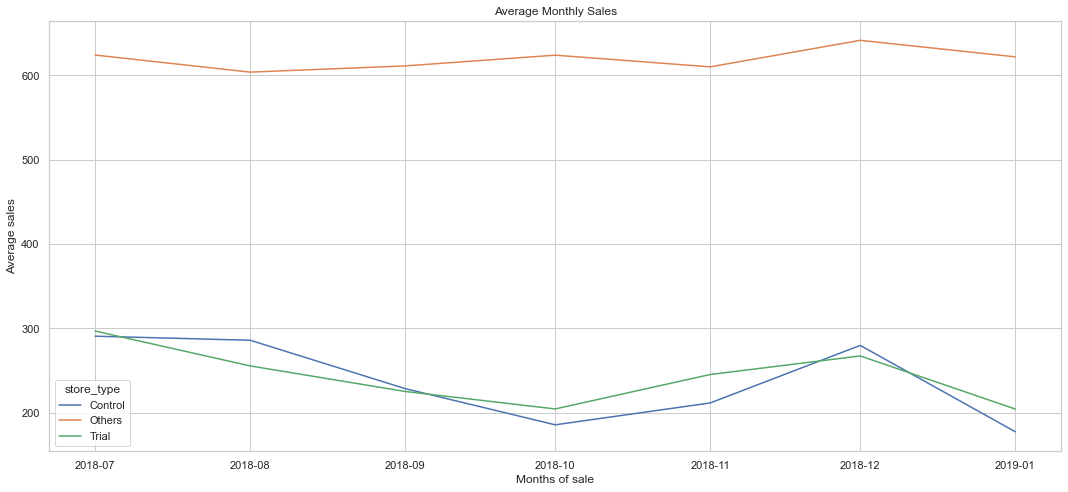

In [21]:
#Creating the plot

plt.figure(figsize = (15,7))
sns.lineplot(data = past_sales, x = "trans_month", y = "mean_monthly_sales", hue = "store_type")
plt.xlabel("Months of sale")
plt.ylabel("Average sales")
plt.title("Average Monthly Sales")
plt.tight_layout()
plt.show()

In [22]:
#Checking for the next metric, number of customers per month
#Grouping the data

past_cust = measure_over_time_copy.groupby(["store_type", "YEARMONTH"])["num_customers"].mean().reset_index(name = "mean_customer_count")

#Converting to datetime

past_cust["trans_month"] = pd.to_datetime(past_cust["YEARMONTH"]*100 + 1, format = '%Y%m%d')

#Filtering for past_data

past_cust = past_cust[past_cust["YEARMONTH"] < 201902]

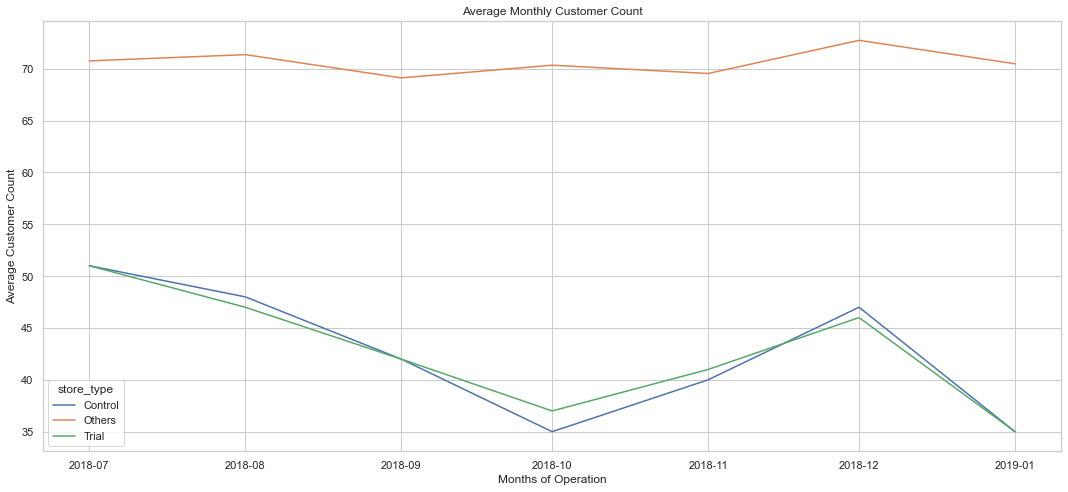

In [23]:
#Plotting the data

plt.figure(figsize = (15,7))
sns.lineplot(data = past_cust, x = "trans_month", y = "mean_customer_count", hue = "store_type")
plt.xlabel("Months of Operation")
plt.ylabel("Average Customer Count")
plt.title("Average Monthly Customer Count")
plt.tight_layout()
plt.show()

#### Assessment of the trial

The trial period goes from the start of March 2019 to June 2019. We now want to see if there has been an
uplift in overall chip sales.
We’ll start with scaling the control store’s sales to a level similar to control for any differences between the
two stores outside of the trial period.

In [24]:
#Scaling pretrial control store's sales to that of the pretrial trial store's sales

trial_sales = pretrial_measures[pretrial_measures["STORE_NBR"] == trial_store]["tot_sales"].sum()

control_sales = pretrial_measures[pretrial_measures["STORE_NBR"] == control_store]["tot_sales"].sum()

scaling_factor_sales = trial_sales/control_sales

In [25]:
measure_control_sales = measure_over_time[measure_over_time["STORE_NBR"] == control_store].copy()

measure_control_sales["control_sales"] = measure_control_sales["tot_sales"]*scaling_factor_sales

In [26]:
measure_control_sales

,STORE_NBR,YEARMONTH,tot_sales,num_customers,num_trans_per_cust,num_chips_per_trans,avg_price_per_unit,control_sales
2699,233,201807,290.7,51,1.058824,44.000000,3.303409,297.565550
2700,233,201808,285.9,48,1.041667,16.000000,3.573750,292.652187
2701,233,201809,228.6,42,1.071429,35.000000,3.265714,233.998916
2702,233,201810,185.7,35,1.028571,28.000000,3.316071,190.085733
2703,233,201811,211.6,40,1.025000,31.000000,3.412903,216.597421
2704,233,201812,279.8,47,1.063830,37.500000,3.730667,286.408121
2705,233,201901,177.5,35,1.000000,23.500000,3.776596,181.692071
2706,233,201902,244.0,45,1.044444,35.000000,3.485714,249.762622
2707,233,201903,199.1,40,1.025000,29.500000,3.374576,203.802205
2708,233,201904,158.6,30,1.066667,23.000000,3.447826,162.345704


In [27]:
#Now let's check the percentage difference between the scaled control store sales and the trial stores sales
#Merging the dataframes on YEARMONTH

merged_df = pd.merge(measure_control_sales[["YEARMONTH","control_sales"]], measure_over_time[measure_over_time["STORE_NBR"] == trial_store][["YEARMONTH", "tot_sales"]], on = "YEARMONTH")

merged_df["percentage_diff"] = abs((merged_df["control_sales"] - merged_df["tot_sales"]) * 100 / merged_df["control_sales"])

In [28]:
merged_df

,YEARMONTH,control_sales,tot_sales,percentage_diff
0,201807,297.565550,296.8,0.257271
1,201808,292.652187,255.5,12.694997
2,201809,233.998916,225.2,3.760238
3,201810,190.085733,204.5,7.583035
4,201811,216.597421,245.3,13.251579
5,201812,286.408121,267.3,6.671641
6,201901,181.692071,204.4,12.498029
7,201902,249.762622,235.0,5.910661
8,201903,203.802205,278.5,36.652103
9,201904,162.345704,263.5,62.307960


As our null hypothesis is that the trial period is the same as the
pre‐trial period, let's take the standard deviation based on the scaled
percentage difference in the pre‐trial period


In [29]:
#Let's calculate the standard deviation for the pre trial period
stdev = merged_df[merged_df["YEARMONTH"] < 201902]["percentage_diff"].std()

#Defining the degrees of freedom
deg = 7

#Calculate the tvalue

merged_df["tvalue"] = (merged_df["percentage_diff"] - 0)/stdev

#Adding transaction month

merged_df["trans_month"] = pd.to_datetime((merged_df["YEARMONTH"] * 100) + 1, format = '%Y%m%d')

#Filter the data for the trial period

merged_df_trial = merged_df[(merged_df["YEARMONTH"] > 201901) & (merged_df["YEARMONTH"] < 201905)].copy()

In [30]:
merged_df_trial[["YEARMONTH", "tvalue"]]

,YEARMONTH,tvalue
7,201902,1.183534
8,201903,7.339116
9,201904,12.476373


In [31]:
#Let's calculate the 95th percentile of the t-distribution on the given degrees of freedom

stats.t.ppf(0.95, df = deg)



1.894578605061305

We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March
and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the
control store.
Let’s create a more visual version of this by plotting the sales of the control store, the sales of the trial stores
and the 95th percentile value of sales of the control store.

In [32]:
#We can use the previously created copy of the measure_over_time dataframe for this

control_trial = measure_over_time_copy[measure_over_time_copy["store_type"].isin(["Trial", "Control"])]


In [33]:
#Grouping for YEARMONTH and Store Type

control_trial_sales = control_trial.groupby(["YEARMONTH", "store_type"])["tot_sales"].mean().reset_index()

In [34]:
control_trial_sales["trans_month"] = pd.to_datetime(control_trial_sales["YEARMONTH"] * 100 + 1, format = '%Y%m%d')

In [35]:
#Calculating 95th and 5th percentile of control store sales

control_95 = control_trial_sales[control_trial_sales["store_type"] == "Control"].copy()
control_95["tot_sales"] = control_95["tot_sales"] + (1.645 * stdev)
control_95["store_type"] = "Control 95th Percentile"

control_5 = control_trial_sales[control_trial_sales["store_type"] == "Control"].copy()
control_5["tot_sales"] = control_5["tot_sales"] - (1.645 * stdev)
control_5["store_type"] = "Control 5th Percentile"

assessment_df = pd.concat([control_trial_sales, control_95, control_5], ignore_index = True)

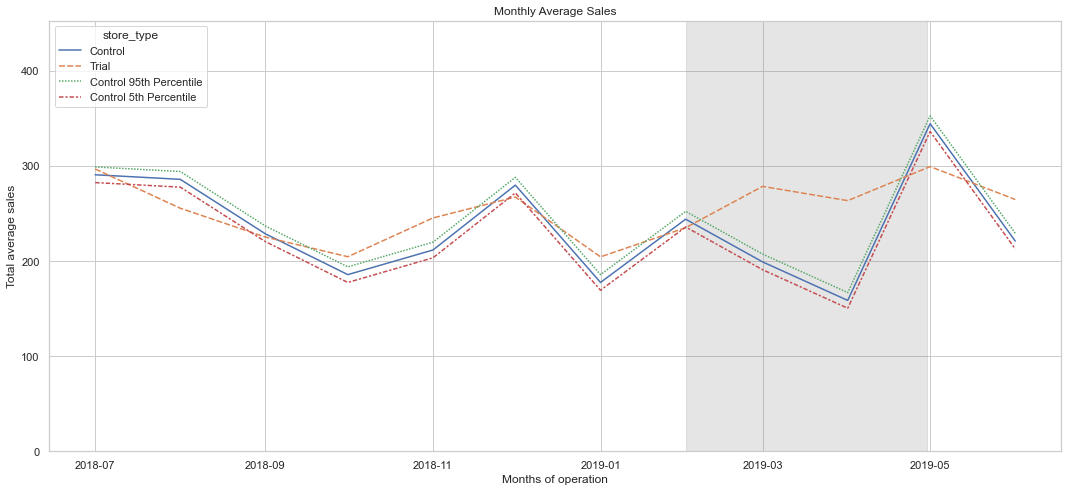

In [36]:
#Generating a plot

plt.figure(figsize = (15,7))
sns.lineplot(data = assessment_df, x = "trans_month", y = "tot_sales", hue = "store_type", style = "store_type")
plt.axvspan(pd.to_datetime('2019-02-01'), pd.to_datetime('2019-04-30'), color='grey', alpha=0.2)
plt.ylim(0, assessment_df['tot_sales'].max() + 100)
plt.xlabel("Months of operation")
plt.ylabel("Total average sales")
plt.title("Monthly Average Sales")
plt.tight_layout()
plt.show()

The results show that the trial in store 77 is significantly different to its control store in the trial period as
the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the
three trial months.
Let’s have a look at assessing this for number of customers as well

In [37]:
#### This would be a repeat of the steps before for total sales
#### Scale pre‐trial control customers to match pre‐trial trial store customers
scaling_factor_cust = (pretrial_measures[pretrial_measures["STORE_NBR"] == trial_store]["tot_sales"].sum())/(pretrial_measures[pretrial_measures["STORE_NBR"] == control_store]["tot_sales"].sum())

measure_control_cust = measure_over_time[measure_over_time["STORE_NBR"] == control_store].copy()

measure_control_cust["control_customers"] = measure_control_cust["num_customers"]*scaling_factor_cust

In [38]:
measure_control_cust

,STORE_NBR,YEARMONTH,tot_sales,num_customers,num_trans_per_cust,num_chips_per_trans,avg_price_per_unit,control_customers
2699,233,201807,290.7,51,1.058824,44.000000,3.303409,52.204482
2700,233,201808,285.9,48,1.041667,16.000000,3.573750,49.133631
2701,233,201809,228.6,42,1.071429,35.000000,3.265714,42.991927
2702,233,201810,185.7,35,1.028571,28.000000,3.316071,35.826606
2703,233,201811,211.6,40,1.025000,31.000000,3.412903,40.944692
2704,233,201812,279.8,47,1.063830,37.500000,3.730667,48.110013
2705,233,201901,177.5,35,1.000000,23.500000,3.776596,35.826606
2706,233,201902,244.0,45,1.044444,35.000000,3.485714,46.062779
2707,233,201903,199.1,40,1.025000,29.500000,3.374576,40.944692
2708,233,201904,158.6,30,1.066667,23.000000,3.447826,30.708519


In [39]:
#Calculating percentage difference between the customer numbers

merged_df = pd.merge(measure_control_cust[["YEARMONTH", "control_customers"]], measure_over_time[measure_over_time["STORE_NBR"] == trial_store][["YEARMONTH", "num_customers"]], on = "YEARMONTH")

merged_df["percentage_diff"] = abs((merged_df["control_customers"] - merged_df["num_customers"]) * 100/ merged_df["control_customers"])

As our null hypothesis is that the trial period is the same as the
pre‐trial period, let's take the standard deviation based on the scaled
percentage difference in the pre‐trial period


In [40]:
#Let's calculate the standard deviation for the pre trial period
stdev = merged_df[merged_df["YEARMONTH"] < 201902]["percentage_diff"].std()

#Defining the degrees of freedom
deg = 7

#Calculate the tvalue

merged_df["tvalue"] = (merged_df["percentage_diff"] - 0)/stdev

#Adding transaction month

merged_df["trans_month"] = pd.to_datetime((merged_df["YEARMONTH"] * 100) + 1, format = '%Y%m%d')

#Filter the data for the trial period

merged_df_trial = merged_df[(merged_df["YEARMONTH"] > 201901) & (merged_df["YEARMONTH"] < 201905)].copy()

In [41]:
merged_df_trial[["YEARMONTH", "tvalue"]]

,YEARMONTH,tvalue
7,201902,1.573002
8,201903,15.077949
9,201904,36.169155


In [42]:
#Let's calculate the 95th percentile of the t-distribution on the given degrees of freedom

stats.t.ppf(0.95, df = deg)

1.894578605061305

We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March
and April - i.e. the increase in customer numbers in the trial store in March and April is statistically greater than in the
control store.
Let’s create a more visual version of this by plotting the customer count of the control store, the customer count of the trial stores
and the 95th percentile value of customer count of the control store.

In [43]:
#We can use the previously created copy of the measure_over_time dataframe for this

control_trial = measure_over_time_copy[measure_over_time_copy["store_type"].isin(["Trial", "Control"])]

In [44]:
#Grouping for YEARMONTH and Store Type

control_trial_cust = control_trial.groupby(["YEARMONTH", "store_type"])["num_customers"].mean().reset_index()

In [45]:
control_trial_cust["trans_month"] = pd.to_datetime(control_trial_cust["YEARMONTH"] * 100 + 1, format = '%Y%m%d')

In [46]:
#Calculating 95th and 5th percentile of control store customer count

control_95 = control_trial_cust[control_trial_cust["store_type"] == "Control"].copy()
control_95["num_customers"] = control_95["num_customers"] + (1.645 * stdev)
control_95["store_type"] = "Control 95th Percentile"

control_5 = control_trial_cust[control_trial_cust["store_type"] == "Control"].copy()
control_5["num_customers"] = control_5["num_customers"] - (1.645 * stdev)
control_5["store_type"] = "Control 5th Percentile"

assessment_df = pd.concat([control_trial_cust, control_95, control_5], ignore_index = True)

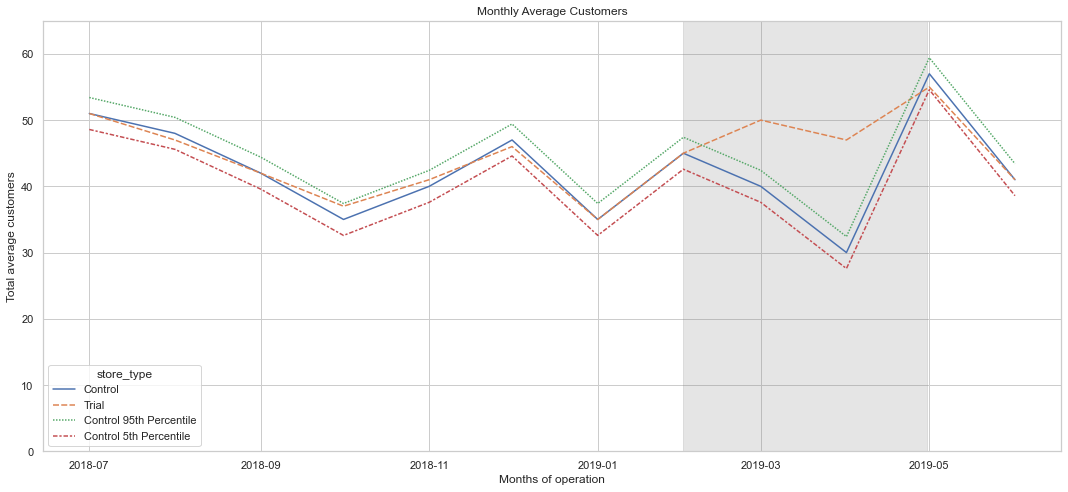

In [47]:
#Generating a plot

plt.figure(figsize = (15,7))
sns.lineplot(data = assessment_df, x = "trans_month", y = "num_customers", style = "store_type", hue = "store_type")
plt.axvspan(pd.to_datetime('2019-02-01'), pd.to_datetime('2019-04-30'), color='grey', alpha=0.2)
plt.ylim(0,65)
plt.xlabel("Months of operation")
plt.ylabel("Total average customers")
plt.title("Monthly Average Customers")
plt.tight_layout()
plt.show()

The results show that the trial in store 77 is significantly different to its control store in the trial period as
the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the
three trial months.

Now, we should repeat these processes for the next 2 control stores.

In [48]:
#Starting for trial store 86
trial_store = 86

corr_sales = Calculate_Correlation(pretrial_measures, 'tot_sales', trial_store)

corr_cust = Calculate_Correlation(pretrial_measures, 'num_customers', trial_store)

print("The correlation for sales between each store against store #86 is:\n", corr_sales)
print("The correlation for number of customers between each store against store #86 is:\n", corr_cust)

The correlation for sales between each store against store #86 is:
      Store1  Store2  correlation_measure
0        86       1             0.445632
1        86       2            -0.403835
2        86       3            -0.261284
3        86       4            -0.039035
4        86       5             0.235159
..      ...     ...                  ...
255      86     268            -0.452182
256      86     269             0.697055
257      86     270            -0.730679
258      86     271             0.527637
259      86     272             0.004926

[260 rows x 3 columns]
The correlation for number of customers between each store against store #86 is:
      Store1  Store2  correlation_measure
0        86       1             0.485831
1        86       2            -0.086161
2        86       3            -0.353786
3        86       4            -0.169608
4        86       5            -0.253229
..      ...     ...                  ...
255      86     268            -0.034273
256   

In [49]:
mean_dist_sales = Calculate_Abs_Difference(pretrial_measures, 'tot_sales', trial_store)

mean_dist_cust = Calculate_Abs_Difference(pretrial_measures, 'num_customers', trial_store)

print("The mean difference between each store and the trial store against total sales is:\n", mean_dist_sales)
print("The mean difference between each store and the trial store against number of customers is:\n", mean_dist_cust)

The mean difference between each store and the trial store against total sales is:
      Store1  Store2  mean_dist
0        86       1   0.220187
1        86       2   0.179315
2        86       3   0.761272
3        86       4   0.497384
4        86       5   0.927731
..      ...     ...        ...
255      86     268   0.250356
256      86     269   0.900338
257      86     270   0.832849
258      86     271   0.921208
259      86     272   0.445911

[260 rows x 3 columns]
The mean difference between each store and the trial store against number of customers is:
      Store1  Store2  mean_dist
0        86       1   0.444597
1        86       2   0.380620
2        86       3   0.911850
3        86       4   0.773922
4        86       5   0.926509
..      ...     ...        ...
255      86     268   0.427390
256      86     269   0.917082
257      86     270   0.890489
258      86     271   0.935896
259      86     272   0.425196

[260 rows x 3 columns]


In [50]:
#Let's set the weight for the correlation score
corr_weight = 0.5

#Merging the tables so that the combined score can be calculated

combined_sales = pd.merge(corr_sales, mean_dist_sales, on = ["Store1", "Store2"])

combined_sales["sales_score"] = combined_sales["correlation_measure"]*corr_weight + combined_sales["mean_dist"]*(1-corr_weight)


combined_cust = pd.merge(corr_cust, mean_dist_cust, on = ["Store1", "Store2"])

combined_cust["customer_score"] = combined_cust["correlation_measure"]*corr_weight + combined_cust["mean_dist"]*(1-corr_weight)

In [51]:
final_df = pd.merge(combined_sales, combined_cust, on = ["Store1", "Store2"])
final_df["averagescore"] = final_df["sales_score"]*0.5 + final_df["customer_score"]*0.5

In [52]:
#Let's find the store with the highest average score other than the trial_store itself
final_df = final_df[~(final_df['Store2'] == trial_store)]

control_store = final_df.sort_values(by = "averagescore", ascending = False).iloc[0]["Store2"]

print("The store with the highest score is: ", control_store)

The store with the highest score is:  155.0


Now, we need to look at the main metrics of the trial, control stores comparing with the rest of the stores to see how similar they are with respect to the others

In [53]:
control_store = 155

#Filtering out past data only for measurement

measure_over_time_copy = measure_over_time.copy()

measure_over_time_copy["store_type"] = np.where(measure_over_time_copy['STORE_NBR'] == trial_store, 'Trial',
                                           np.where(measure_over_time_copy['STORE_NBR'] == control_store, 'Control', 'Others'))

In [54]:
#Calculating average sales per month for each store type
past_sales = measure_over_time_copy.groupby(["store_type","YEARMONTH"])['tot_sales'].mean().reset_index(name = "mean_monthly_sales")

#Creating transaction month column


past_sales["trans_month"] = pd.to_datetime(past_sales["YEARMONTH"].astype(str)+'01', format = '%Y%m%d')

#Filtering for past data
past_sales = past_sales[past_sales["YEARMONTH"] < 201902]


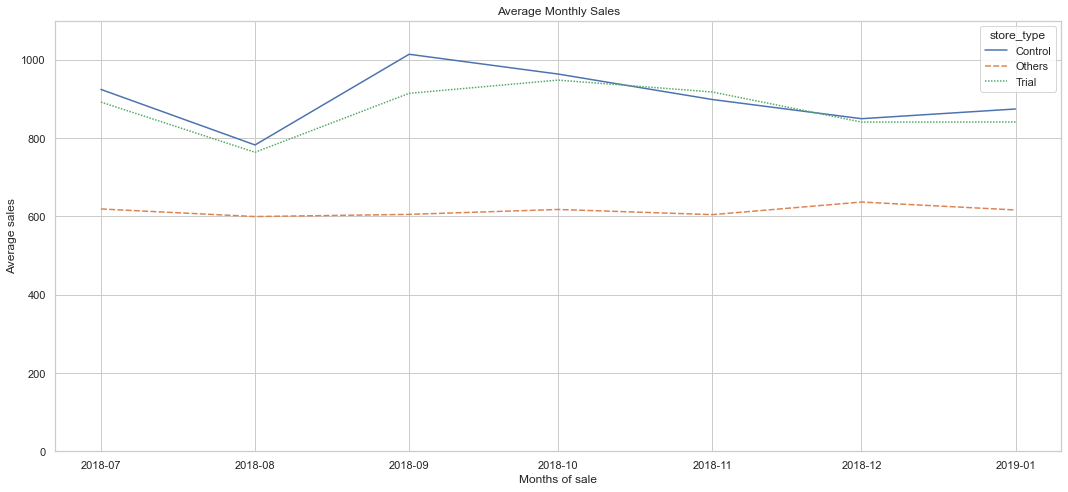

In [55]:
#Creating the plot

plt.figure(figsize = (15,7))
sns.lineplot(data = past_sales, x = "trans_month", y = "mean_monthly_sales", hue = "store_type", style = "store_type")
plt.ylim(0,1100)
plt.xlabel("Months of sale")
plt.ylabel("Average sales")
plt.title("Average Monthly Sales")
plt.tight_layout()
plt.show()

In [56]:
#Checking for the next metric, number of customers per month
#Grouping the data

past_cust = measure_over_time_copy.groupby(["store_type", "YEARMONTH"])["num_customers"].mean().reset_index(name = "mean_customer_count")

#Converting to datetime

past_cust["trans_month"] = pd.to_datetime(past_cust["YEARMONTH"]*100 + 1, format = '%Y%m%d')

#Filtering for past_data

past_cust = past_cust[past_cust["YEARMONTH"] < 201902]

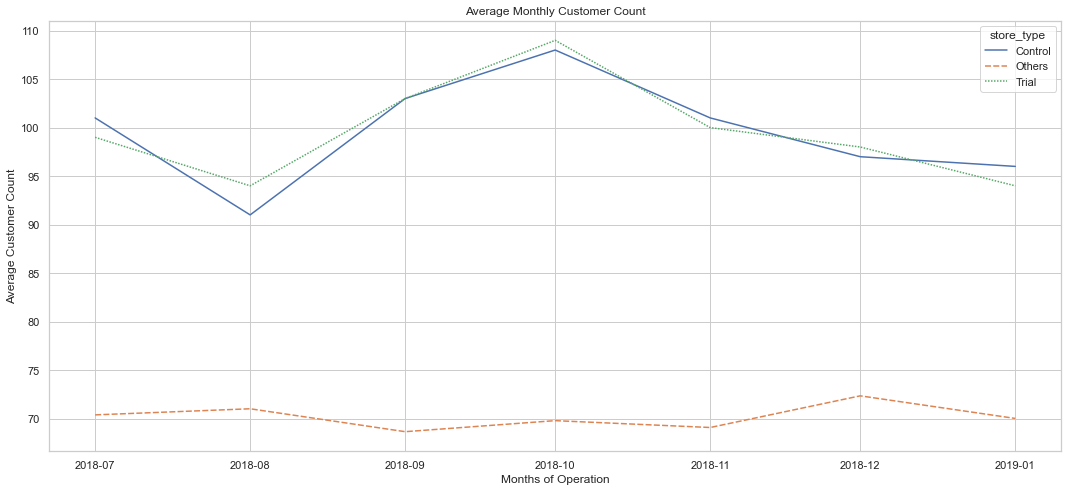

In [57]:
#Plotting the data

plt.figure(figsize = (15,7))
sns.lineplot(data = past_cust, x = "trans_month", y = "mean_customer_count", hue = "store_type", style = "store_type")
plt.xlabel("Months of Operation")
plt.ylabel("Average Customer Count")
plt.title("Average Monthly Customer Count")
plt.tight_layout()
plt.show()

#### Assessment of the trial

The trial period goes from the start of March 2019 to June 2019. We now want to see if there has been an
uplift in overall chip sales.
We’ll start with scaling the control store’s sales to a level similar to control for any differences between the
two stores outside of the trial period.

In [58]:
#Scaling pretrial control store's sales to that of the pretrial trial store's sales

scaling_factor_sales = pretrial_measures[pretrial_measures["STORE_NBR"] == trial_store]["tot_sales"].sum()/pretrial_measures[pretrial_measures["STORE_NBR"] == control_store]["tot_sales"].sum()

In [59]:
measure_control_sales = measure_over_time[measure_over_time["STORE_NBR"] == control_store].copy()

measure_control_sales["control_sales"] = measure_control_sales["tot_sales"]*scaling_factor_sales

In [60]:
measure_control_sales

,STORE_NBR,YEARMONTH,tot_sales,num_customers,num_trans_per_cust,num_chips_per_trans,avg_price_per_unit,control_sales
1793,155,201807,924.60,101,1.217822,250.000000,3.698400,896.922236
1794,155,201808,782.70,91,1.307692,76.333333,3.417904,759.269991
1795,155,201809,1014.40,103,1.398058,290.000000,3.497931,984.034086
1796,155,201810,963.80,108,1.259259,272.000000,3.543382,934.948790
1797,155,201811,898.80,101,1.316832,270.000000,3.328889,871.894555
1798,155,201812,849.80,97,1.237113,242.000000,3.511570,824.361363
1799,155,201901,874.60,96,1.302083,252.000000,3.470635,848.418979
1800,155,201902,891.20,95,1.315789,254.000000,3.508661,864.522060
1801,155,201903,804.40,94,1.255319,240.000000,3.351667,780.320405
1802,155,201904,844.60,99,1.212121,242.000000,3.490083,819.317024


In [61]:
#Now let's check the percentage difference between the scaled control store sales and the trial stores sales
#Merging the dataframes on YEARMONTH

merged_df = pd.merge(measure_control_sales[["YEARMONTH","control_sales"]], measure_over_time[measure_over_time["STORE_NBR"] == trial_store][["YEARMONTH", "tot_sales"]], on = "YEARMONTH")

merged_df["percentage_diff"] = abs((merged_df["control_sales"] - merged_df["tot_sales"]) * 100 / merged_df["control_sales"])

As our null hypothesis is that the trial period is the same as the
pre‐trial period, let's take the standard deviation based on the scaled
percentage difference in the pre‐trial period


In [62]:
#Let's calculate the standard deviation for the pre trial period
stdev = merged_df[merged_df["YEARMONTH"] < 201902]["percentage_diff"].std()

#Defining the degrees of freedom
deg = 7

#Calculate the tvalue

merged_df["tvalue"] = (merged_df["percentage_diff"] - 0)/stdev

#Adding transaction month

merged_df["trans_month"] = pd.to_datetime((merged_df["YEARMONTH"] * 100) + 1, format = '%Y%m%d')

#Filter the data for the trial period

merged_df_trial = merged_df[(merged_df["YEARMONTH"] > 201901) & (merged_df["YEARMONTH"] < 201905)].copy()

In [63]:
merged_df_trial[["YEARMONTH", "tvalue"]]

,YEARMONTH,tvalue
7,201902,2.179542
8,201903,12.226922
9,201904,1.364580


In [64]:
#Let's calculate the 95th percentile of the t-distribution on the given degrees of freedom

stats.t.ppf(0.95, df = deg)

1.894578605061305

We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March
but it is less for April - i.e. the increase in sales in the trial store in March is statistically greater than in the control store but not for April.
Let’s create a more visual version of this by plotting the sales of the control store, the sales of the trial stores and the 95th percentile value of sales of the control store.

In [65]:
#We can use the previously created copy of the measure_over_time dataframe for this

control_trial = measure_over_time_copy[measure_over_time_copy["store_type"].isin(["Trial", "Control"])]

In [66]:
#Grouping for YEARMONTH and Store Type

control_trial_sales = control_trial.groupby(["YEARMONTH", "store_type"])["tot_sales"].mean().reset_index()

In [67]:
control_trial_sales["trans_month"] = pd.to_datetime(control_trial_sales["YEARMONTH"] * 100 + 1, format = '%Y%m%d')

#Calculating 95th and 5th percentile of control store sales

control_95 = control_trial_sales[control_trial_sales["store_type"] == "Control"].copy()
control_95["tot_sales"] = control_95["tot_sales"] + (1.645 * stdev)
control_95["store_type"] = "Control 95th Percentile"

control_5 = control_trial_sales[control_trial_sales["store_type"] == "Control"].copy()
control_5["tot_sales"] = control_5["tot_sales"] - (1.645 * stdev)
control_5["store_type"] = "Control 5th Percentile"

assessment_df = pd.concat([control_trial_sales, control_95, control_5], ignore_index = True)

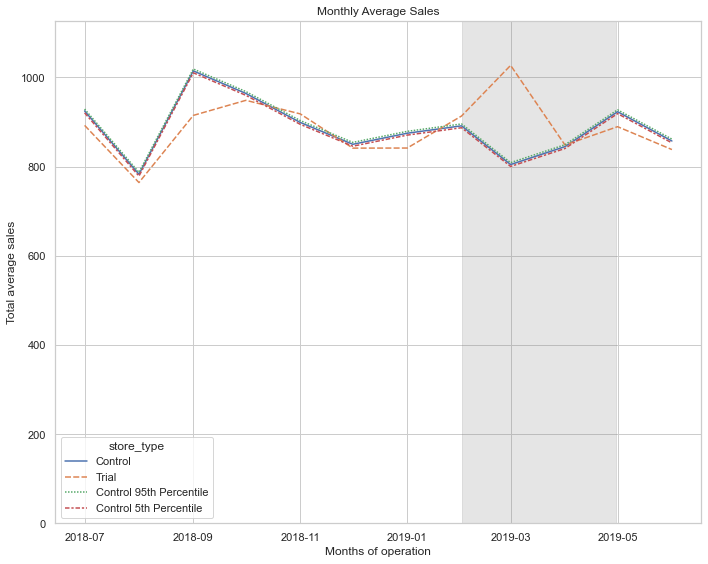

In [68]:
#Generating a plot

plt.figure(figsize = (10,8))
sns.lineplot(data = assessment_df, x = "trans_month", y = "tot_sales", hue = "store_type", style = "store_type")
plt.axvspan(pd.to_datetime('2019-02-01'), pd.to_datetime('2019-04-30'), color='grey', alpha=0.2)
plt.ylim(0, assessment_df['tot_sales'].max() + 100)
plt.xlabel("Months of operation")
plt.ylabel("Total average sales")
plt.title("Monthly Average Sales")
plt.tight_layout()
plt.show()

The results show that the trial in store 86 is not significantly different to its control store in the trial period
as the trial store performance lies inside the 5% to 95% confidence interval of the control store in two of the
three trial months.
Let’s have a look at assessing this for number of customers as well.

In [69]:
#### This would be a repeat of the steps before for total sales
#### Scale pre‐trial control customers to match pre‐trial trial store customers
scaling_factor_cust = (pretrial_measures[pretrial_measures["STORE_NBR"] == trial_store]["tot_sales"].sum())/(pretrial_measures[pretrial_measures["STORE_NBR"] == control_store]["tot_sales"].sum())

measure_control_cust = measure_over_time[measure_over_time["STORE_NBR"] == control_store].copy()

measure_control_cust["control_customers"] = measure_control_cust["num_customers"]*scaling_factor_cust

In [70]:
#Calculating percentage difference between the customer numbers

merged_df = pd.merge(measure_control_cust[["YEARMONTH", "control_customers"]], measure_over_time[measure_over_time["STORE_NBR"] == trial_store][["YEARMONTH", "num_customers"]], on = "YEARMONTH")

merged_df["percentage_diff"] = abs((merged_df["control_customers"] - merged_df["num_customers"]) * 100/ merged_df["control_customers"])

As our null hypothesis is that the trial period is the same as the
pre‐trial period, let's take the standard deviation based on the scaled
percentage difference in the pre‐trial period


In [71]:
#Let's calculate the standard deviation for the pre trial period
stdev = merged_df[merged_df["YEARMONTH"] < 201902]["percentage_diff"].std()

#Defining the degrees of freedom
deg = 7

#Calculate the tvalue

merged_df["tvalue"] = (merged_df["percentage_diff"] - 0)/stdev

#Adding transaction month

merged_df["trans_month"] = pd.to_datetime((merged_df["YEARMONTH"] * 100) + 1, format = '%Y%m%d')

#Filter the data for the trial period

merged_df_trial = merged_df[(merged_df["YEARMONTH"] > 201901) & (merged_df["YEARMONTH"] < 201905)].copy()

In [72]:
merged_df_trial[["YEARMONTH", "tvalue"]]

,YEARMONTH,tvalue
7,201902,8.155393
8,201903,13.222857
9,201904,4.725720


We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March
and April - i.e. the increase in customer numbers in the trial store in March and April is statistically greater than in the
control store.
Let’s create a more visual version of this by plotting the customer count of the control store, the customer count of the trial stores
and the 95th percentile value of customer count of the control store.

In [73]:
#We can use the previously created copy of the measure_over_time dataframe for this

control_trial = measure_over_time_copy[measure_over_time_copy["store_type"].isin(["Trial", "Control"])]

In [74]:
#Grouping for YEARMONTH and Store Type

control_trial_cust = control_trial.groupby(["YEARMONTH", "store_type"])["num_customers"].mean().reset_index()

control_trial_cust["trans_month"] = pd.to_datetime(control_trial_cust["YEARMONTH"] * 100 + 1, format = '%Y%m%d')

In [75]:
#Calculating 95th and 5th percentile of control store customer count

control_95 = control_trial_cust[control_trial_cust["store_type"] == "Control"].copy()
control_95["num_customers"] = control_95["num_customers"] + (1.645 * stdev)
control_95["store_type"] = "Control 95th Percentile"

control_5 = control_trial_cust[control_trial_cust["store_type"] == "Control"].copy()
control_5["num_customers"] = control_5["num_customers"] - (1.645 * stdev)
control_5["store_type"] = "Control 5th Percentile"

assessment_df = pd.concat([control_trial_cust, control_95, control_5], ignore_index = True)

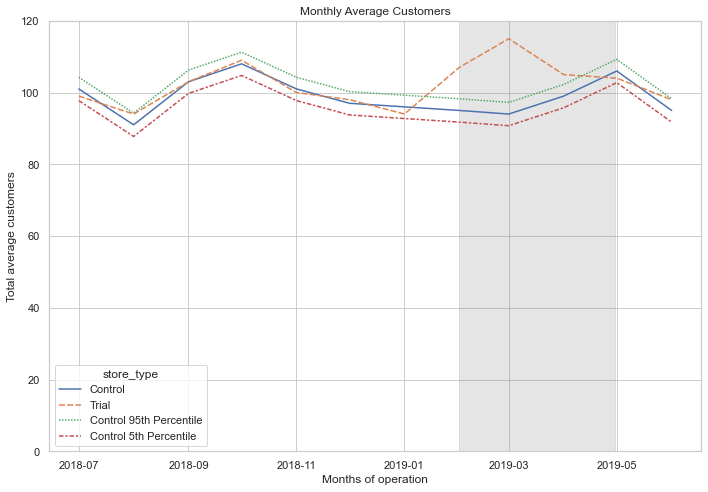

In [76]:
#Generating a plot

plt.figure(figsize = (10,7))
sns.lineplot(data = assessment_df, x = "trans_month", y = "num_customers", style = "store_type", hue = "store_type")
plt.axvspan(pd.to_datetime('2019-02-01'), pd.to_datetime('2019-04-30'), color='grey', alpha=0.2)
plt.ylim(0, 120)
plt.xlabel("Months of operation")
plt.ylabel("Total average customers")
plt.title("Monthly Average Customers")
plt.tight_layout()
plt.show()

It looks like the number of customers is significantly higher in all of the three months. This seems to
suggest that the trial had a significant impact on increasing the number of customers in trial store 86 but
as we saw, sales were not significantly higher. We should check with the Category Manager if there were
special deals in the trial store that were may have resulted in lower prices, impacting the results.

Now we can look at store number 88

In [77]:
#Starting for trial store 88
trial_store = 88

corr_sales = Calculate_Correlation(pretrial_measures, "tot_sales", trial_store)

corr_cust = Calculate_Correlation(pretrial_measures, "num_customers", trial_store)

print("The correlation for sales between each store against store #88 is:\n", corr_sales)
print("The correlation for number of customers between each store against store #88 is:\n", corr_cust)

The correlation for sales between each store against store #88 is:
      Store1  Store2  correlation_measure
0        88       1             0.813636
1        88       2            -0.067927
2        88       3            -0.507847
3        88       4            -0.745566
4        88       5             0.190330
..      ...     ...                  ...
255      88     268            -0.021429
256      88     269            -0.172578
257      88     270            -0.723272
258      88     271            -0.103037
259      88     272            -0.772772

[260 rows x 3 columns]
The correlation for number of customers between each store against store #88 is:
      Store1  Store2  correlation_measure
0        88       1             0.305334
1        88       2            -0.452379
2        88       3             0.522884
3        88       4            -0.361503
4        88       5            -0.025320
..      ...     ...                  ...
255      88     268             0.672672
256   

In [78]:
mean_dist_sales = Calculate_Abs_Difference(pretrial_measures, 'tot_sales', trial_store)

mean_dist_cust = Calculate_Abs_Difference(pretrial_measures, 'num_customers', trial_store)

print("The mean difference between each store and the trial store against total sales is:\n", mean_dist_sales)
print("The mean difference between each store and the trial store against number of customers is:\n", mean_dist_cust)

The mean difference between each store and the trial store against total sales is:
      Store1  Store2  mean_dist
0        88       1   0.142830
1        88       2   0.115895
2        88       3   0.802803
3        88       4   0.897661
4        88       5   0.610161
..      ...     ...        ...
255      88     268   0.160968
256      88     269   0.709806
257      88     270   0.714835
258      88     271   0.613314
259      88     272   0.289940

[260 rows x 3 columns]
The mean difference between each store and the trial store against number of customers is:
      Store1  Store2  mean_dist
0        88       1   0.351219
1        88       2   0.300329
2        88       3   0.843685
3        88       4   0.924507
4        88       5   0.737229
..      ...     ...        ...
255      88     268   0.335512
256      88     269   0.847040
257      88     270   0.833427
258      88     271   0.738290
259      88     272   0.334492

[260 rows x 3 columns]


In [79]:
#Let's set the weight for the correlation score
corr_weight = 0.5

#Merging the tables so that the combined score can be calculated

combined_sales = pd.merge(corr_sales, mean_dist_sales, on = ["Store1", "Store2"])

combined_sales["sales_score"] = combined_sales["correlation_measure"]*corr_weight + combined_sales["mean_dist"]*(1-corr_weight)


combined_cust = pd.merge(corr_cust, mean_dist_cust, on = ["Store1", "Store2"])

combined_cust["customer_score"] = combined_cust["correlation_measure"]*corr_weight + combined_cust["mean_dist"]*(1-corr_weight)

In [80]:
final_df = pd.merge(combined_sales, combined_cust, on = ["Store1", "Store2"])
final_df["averagescore"] = final_df["sales_score"]*0.5 + final_df["customer_score"]*0.5

In [81]:
#Let's find the store with the highest average score other than the trial_store itself
final_df = final_df[~(final_df['Store2'] == trial_store)]

control_store = final_df.sort_values(by = "averagescore", ascending = False).iloc[0]["Store2"]

print("The store with the highest score is: ", control_store)

The store with the highest score is:  237.0


Now, we need to look at the main metrics of the trial, control stores comparing with the rest of the stores to see how similar they are with respect to the others

In [82]:
control_store = 237

#Filtering out past data only for measurement

measure_over_time_copy = measure_over_time.copy()

measure_over_time_copy["store_type"] = np.where(measure_over_time_copy['STORE_NBR'] == trial_store, 'Trial',
                                           np.where(measure_over_time_copy['STORE_NBR'] == control_store, 'Control', 'Others'))

In [83]:
#Calculating average sales per month for each store type
past_sales = measure_over_time_copy.groupby(["store_type","YEARMONTH"])['tot_sales'].mean().reset_index(name = "mean_monthly_sales")

#Creating transaction month column


past_sales["trans_month"] = pd.to_datetime(past_sales["YEARMONTH"].astype(str)+'01', format = '%Y%m%d')

#Filtering for past data
past_sales = past_sales[past_sales["YEARMONTH"] < 201902]


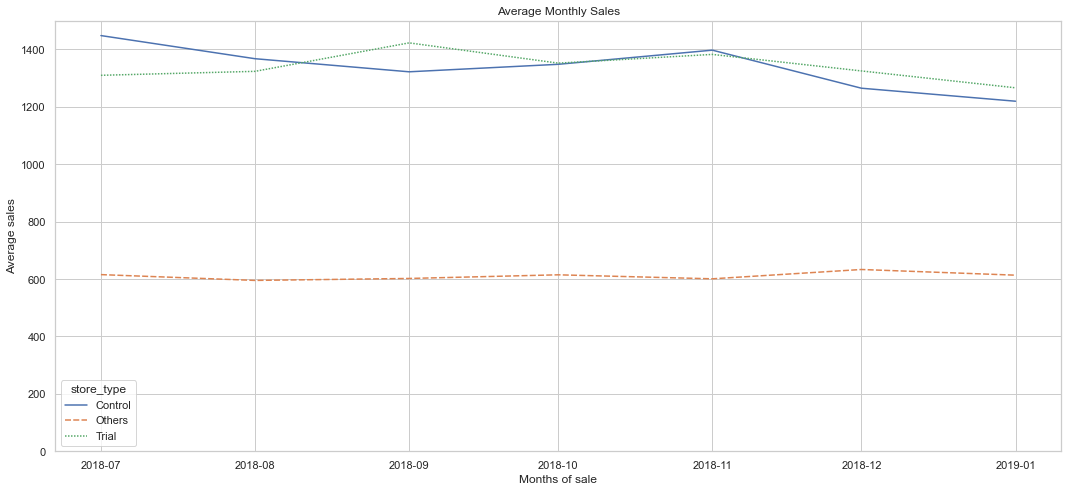

In [84]:
#Creating the plot

plt.figure(figsize = (15,7))
sns.lineplot(data = past_sales, x = "trans_month", y = "mean_monthly_sales", hue = "store_type", style = "store_type")
plt.ylim(0,1500)
plt.xlabel("Months of sale")
plt.ylabel("Average sales")
plt.title("Average Monthly Sales")
plt.tight_layout()
plt.show()

In [85]:
#Checking for the next metric, number of customers per month
#Grouping the data

past_cust = measure_over_time_copy.groupby(["store_type", "YEARMONTH"])["num_customers"].mean().reset_index(name = "mean_customer_count")

#Converting to datetime

past_cust["trans_month"] = pd.to_datetime(past_cust["YEARMONTH"]*100 + 1, format = '%Y%m%d')

#Filtering for past_data

past_cust = past_cust[past_cust["YEARMONTH"] < 201902]

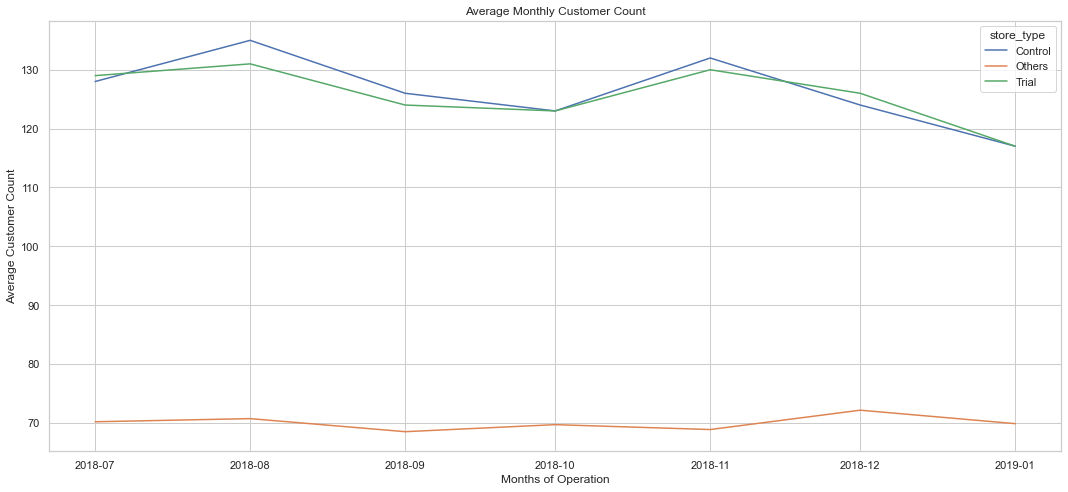

In [86]:
#Plotting the data

plt.figure(figsize = (15,7))
sns.lineplot(data = past_cust, x = "trans_month", y = "mean_customer_count", hue = "store_type")
plt.xlabel("Months of Operation")
plt.ylabel("Average Customer Count")
plt.title("Average Monthly Customer Count")
plt.tight_layout()
plt.show()

#### Assessment of the trial

The trial period goes from the start of March 2019 to June 2019. We now want to see if there has been an
uplift in overall chip sales.
We’ll start with scaling the control store’s sales to a level similar to control for any differences between the
two stores outside of the trial period.

In [87]:
#Scaling pretrial control store's sales to that of the pretrial trial store's sales

scaling_factor_sales = pretrial_measures[pretrial_measures["STORE_NBR"] == trial_store]["tot_sales"].sum()/pretrial_measures[pretrial_measures["STORE_NBR"] == control_store]["tot_sales"].sum()

In [88]:
measure_control_sales = measure_over_time[measure_over_time["STORE_NBR"] == control_store].copy()

measure_control_sales["control_sales"] = measure_control_sales["tot_sales"]*scaling_factor_sales

In [89]:
#Now let's check the percentage difference between the scaled control store sales and the trial stores sales
#Merging the dataframes on YEARMONTH

merged_df = pd.merge(measure_control_sales[["YEARMONTH","control_sales"]], measure_over_time[measure_over_time["STORE_NBR"] == trial_store][["YEARMONTH", "tot_sales"]], on = "YEARMONTH")

merged_df["percentage_diff"] = abs((merged_df["control_sales"] - merged_df["tot_sales"]) * 100 / merged_df["control_sales"])

As our null hypothesis is that the trial period is the same as the
pre‐trial period, let's take the standard deviation based on the scaled
percentage difference in the pre‐trial period


In [90]:
#Let's calculate the standard deviation for the pre trial period
stdev = merged_df[merged_df["YEARMONTH"] < 201902]["percentage_diff"].std()

#Defining the degrees of freedom
deg = 7

#Calculate the tvalue

merged_df["tvalue"] = (merged_df["percentage_diff"] - 0)/stdev

#Adding transaction month

merged_df["trans_month"] = pd.to_datetime((merged_df["YEARMONTH"] * 100) + 1, format = '%Y%m%d')

#Filter the data for the trial period

merged_df_trial = merged_df[(merged_df["YEARMONTH"] > 201901) & (merged_df["YEARMONTH"] < 201905)].copy()

In [91]:
merged_df_trial[["YEARMONTH", "tvalue"] ]

,YEARMONTH,tvalue
7,201902,0.781270
8,201903,6.595668
9,201904,5.768527


We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March
and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the
control store.
Let’s create a more visual version of this by plotting the sales of the control store, the sales of the trial stores
and the 95th percentile value of sales of the control store.

In [92]:
#We can use the previously created copy of the measure_over_time dataframe for this

control_trial = measure_over_time_copy[measure_over_time_copy["store_type"].isin(["Trial", "Control"])]

In [93]:
#Grouping for YEARMONTH and Store Type

control_trial_sales = control_trial.groupby(["YEARMONTH", "store_type"])["tot_sales"].mean().reset_index()

In [94]:
control_trial_sales["trans_month"] = pd.to_datetime(control_trial_sales["YEARMONTH"] * 100 + 1, format = '%Y%m%d')

#Calculating 95th and 5th percentile of control store sales

control_95 = control_trial_sales[control_trial_sales["store_type"] == "Control"].copy()
control_95["tot_sales"] = control_95["tot_sales"] + (1.645 * stdev)
control_95["store_type"] = "Control 95th Percentile"

control_5 = control_trial_sales[control_trial_sales["store_type"] == "Control"].copy()
control_5["tot_sales"] = control_5["tot_sales"] - (1.645 * stdev)
control_5["store_type"] = "Control 5th Percentile"

assessment_df = pd.concat([control_trial_sales, control_95, control_5], ignore_index = True)

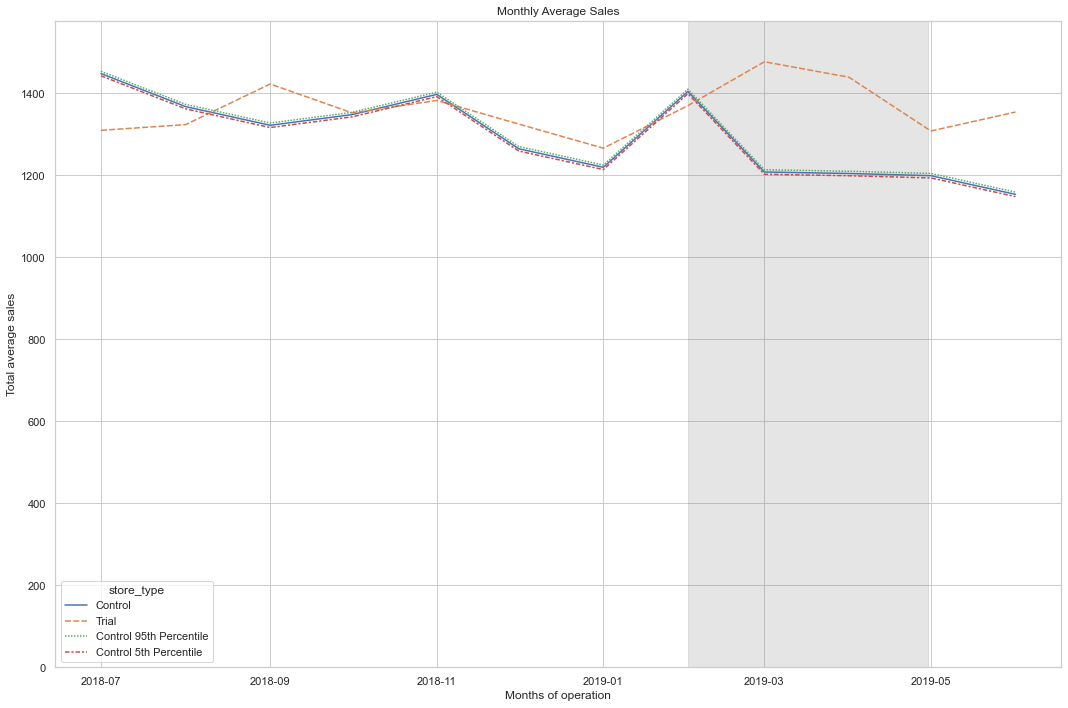

In [95]:
#Generating a plot

plt.figure(figsize = (15,10))
sns.lineplot(data = assessment_df, x = "trans_month", y = "tot_sales", hue = "store_type", style = "store_type")
plt.axvspan(pd.to_datetime('2019-02-01'), pd.to_datetime('2019-04-30'), color='grey', alpha=0.2)
plt.ylim(0, assessment_df['tot_sales'].max() + 100)
plt.xlabel("Months of operation")
plt.ylabel("Total average sales")
plt.title("Monthly Average Sales")
plt.tight_layout()
plt.show()

The results show that the trial in store 88 is significantly different to its control store in the trial period as
the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the
three trial months.
Let’s have a look at assessing this for number of customers as well

In [96]:
#### This would be a repeat of the steps before for total sales
#### Scale pre‐trial control customers to match pre‐trial trial store customers
scaling_factor_cust = (pretrial_measures[pretrial_measures["STORE_NBR"] == trial_store]["tot_sales"].sum())/(pretrial_measures[pretrial_measures["STORE_NBR"] == control_store]["tot_sales"].sum())

measure_control_cust = measure_over_time[measure_over_time["STORE_NBR"] == control_store].copy()

measure_control_cust["control_customers"] = measure_control_cust["num_customers"]*scaling_factor_cust

In [97]:
#Calculating percentage difference between the customer numbers

merged_df = pd.merge(measure_control_cust[["YEARMONTH", "control_customers"]], measure_over_time[measure_over_time["STORE_NBR"] == trial_store][["YEARMONTH", "num_customers"]], on = "YEARMONTH")

merged_df["percentage_diff"] = abs((merged_df["control_customers"] - merged_df["num_customers"]) * 100/ merged_df["control_customers"])

As our null hypothesis is that the trial period is the same as the
pre‐trial period, let's take the standard deviation based on the scaled
percentage difference in the pre‐trial period


In [98]:
#Let's calculate the standard deviation for the pre trial period
stdev = merged_df[merged_df["YEARMONTH"] < 201902]["percentage_diff"].std()

#Defining the degrees of freedom
deg = 7

#Calculate the tvalue

merged_df["tvalue"] = (merged_df["percentage_diff"] - 0)/stdev

#Adding transaction month

merged_df["trans_month"] = pd.to_datetime((merged_df["YEARMONTH"] * 100) + 1, format = '%Y%m%d')

#Filter the data for the trial period

merged_df_trial = merged_df[(merged_df["YEARMONTH"] > 201901) & (merged_df["YEARMONTH"] < 201905)].copy()

In [99]:
merged_df_trial[["YEARMONTH", "tvalue"]]

,YEARMONTH,tvalue
7,201902,1.645185
8,201903,11.749667
9,201904,6.144979


We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March
and April - i.e. the increase in customer numbers in the trial store in March and April is statistically greater than in the
control store.
Let’s create a more visual version of this by plotting the customer count of the control store, the customer count of the trial stores
and the 95th percentile value of customer count of the control store.

In [100]:
#We can use the previously created copy of the measure_over_time dataframe for this

control_trial = measure_over_time_copy[measure_over_time_copy["store_type"].isin(["Trial", "Control"])]

In [101]:
#Grouping for YEARMONTH and Store Type

control_trial_cust = control_trial.groupby(["YEARMONTH", "store_type"])["num_customers"].mean().reset_index()

control_trial_cust["trans_month"] = pd.to_datetime(control_trial_cust["YEARMONTH"] * 100 + 1, format = '%Y%m%d')

In [102]:
#Calculating 95th and 5th percentile of control store customer count

control_95 = control_trial_cust[control_trial_cust["store_type"] == "Control"].copy()
control_95["num_customers"] = control_95["num_customers"] + (1.645 * stdev)
control_95["store_type"] = "Control 95th Percentile"

control_5 = control_trial_cust[control_trial_cust["store_type"] == "Control"].copy()
control_5["num_customers"] = control_5["num_customers"] - (1.645 * stdev)
control_5["store_type"] = "Control 5th Percentile"

assessment_df = pd.concat([control_trial_cust, control_95, control_5], ignore_index = True)

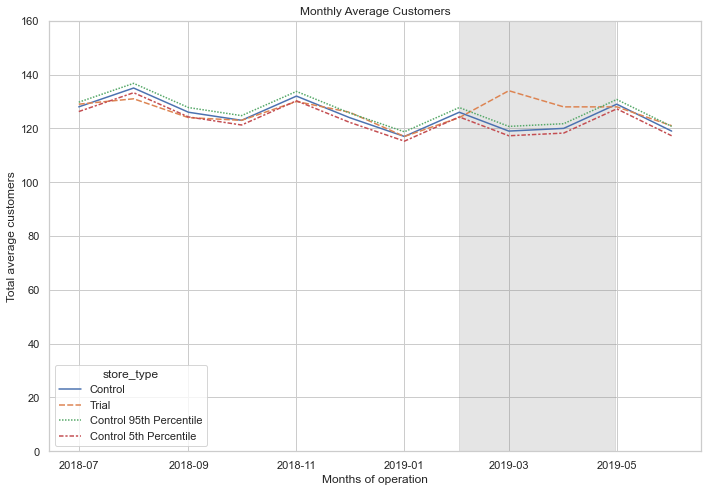

In [103]:
#Generating a plot

plt.figure(figsize = (10,7))
sns.lineplot(data = assessment_df, x = "trans_month", y = "num_customers", style = "store_type", hue = "store_type")
plt.axvspan(pd.to_datetime('2019-02-01'), pd.to_datetime('2019-04-30'), color='grey', alpha=0.2)
plt.ylim(0, 160)
plt.xlabel("Months of operation")
plt.ylabel("Total average customers")
plt.title("Monthly Average Customers")
plt.tight_layout()
plt.show()

Total number of customers in the trial period for the trial store is significantly higher than the control store
for two out of three months, which indicates a positive trial effect.

#### Conclusion

We’ve found control stores 233, 155, 237 for trial stores 77, 86 and 88 respectively.
The results for trial stores 77 and 88 during the trial period show a significant difference in at least two of the
three trial months but this is not the case for trial store 86. We can check with the client if the implementation
of the trial was different in trial store 86 but overall, the trial shows a significant increase in sales. Now that
we have finished our analysis, we can prepare our presentation to the Category Manager.